The standard event study plot — point estimates with 95% pointwise confidence intervals — is ubiquitous in applied economics. But it leaves a surprising amount of information on the table.

[Freyaldenhoven, Hansen, Pérez & Shapiro (2021)](https://doi.org/10.3386/w29170) proposed several practical enhancements that make event study plots more informative, more honest, and easier to interpret. Most of these are simple to implement yet rarely used in practice.

In this post, we implement five enhancements using the [`diff-diff`](https://github.com/igerber/diff-diff) Python package:

1. **Simultaneous confidence bands** — correct for multiple testing across periods
2. **Parenthetical outcome labels** — show the baseline outcome level for economic interpretation
3. **Joint pre-trend Wald test** — formal test instead of visual inspection
4. **Leveling-off test** — are post-treatment effects constant over time?
5. **Putting it all together** — a complete "best practices" event study plot

Each enhancement builds on the previous one. By the end, we will have transformed a standard event study into a much richer visualization.

# Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as scipy_stats

from diff_diff import MultiPeriodDiD, generate_did_data

import warnings
warnings.filterwarnings("ignore")

np.random.seed(42)

c:\Users\danny\anaconda3\Lib\site-packages\pandas\core\computation\expressions.py:22: UserWarning: Pandas requires version '2.10.2' or newer of 'numexpr' (version '2.8.7' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\danny\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:56: UserWarning: Pandas requires version '1.4.2' or newer of 'bottleneck' (version '1.3.7' currently installed).
  from pandas.core import (


We generate panel data with 200 units over 10 periods, where treatment begins at period 5. The true treatment effect is 3.0, and we include a slight time trend to make the example realistic.

In [2]:
# Generate panel data
data = generate_did_data(
    n_units=200,
    n_periods=10,
    treatment_effect=3.0,
    treatment_fraction=0.4,
    treatment_period=5,
    noise_sd=2.0,
    seed=42
)

# Fit event study
did = MultiPeriodDiD()
results = did.fit(
    data,
    outcome='outcome',
    treatment='treated',
    time='period',
    post_periods=[5, 6, 7, 8, 9],
    reference_period=4,
    unit='unit',
)

results.print_summary()

           Multi-Period Difference-in-Differences Estimation Results            

Observations:                   2000
Treated observations:            800
Control observations:           1200
Pre-treatment periods:             5
Post-treatment periods:            5
R-squared:                    0.4288

--------------------------------------------------------------------------------
                   Pre-Period Effects (Parallel Trends Test)                    
--------------------------------------------------------------------------------
Period              Estimate    Std. Err.     t-stat      P>|t|   Sig.
--------------------------------------------------------------------------------
0                    -0.1379       0.5116     -0.270     0.7875       
1                     0.0645       0.4904      0.132     0.8953       
2                     0.4116       0.4916      0.837     0.4025       
3                    -0.3952       0.5158     -0.766     0.4436       
[ref: 4]        

Let's first see the standard event study plot — point estimates with pointwise 95% CIs:

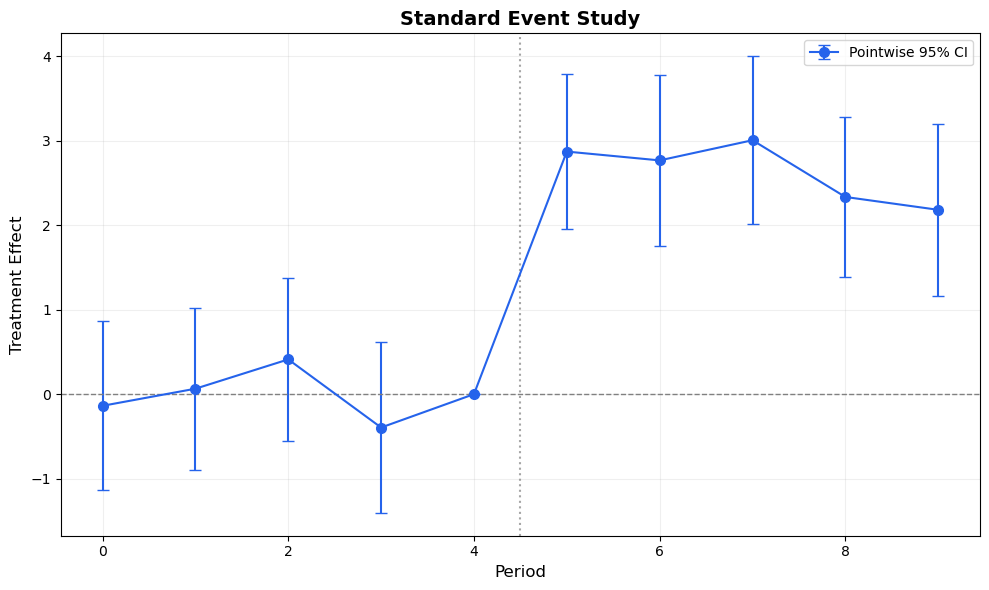

In [3]:
#| label: fig-baseline
#| fig-cap: "Standard event study plot with pointwise 95% confidence intervals. This is what most papers show — but it can be improved."
#| code-fold: true

# Extract data from results
ref_period = results.reference_period
periods_all = sorted(results.period_effects.keys())
estimates = [results.period_effects[p].effect for p in periods_all]
ses = [results.period_effects[p].se for p in periods_all]

# Add reference period (beta = 0, se = 0)
periods_plot = sorted(periods_all + [ref_period])
est_plot = []
se_plot = []
for p in periods_plot:
    if p == ref_period:
        est_plot.append(0.0)
        se_plot.append(0.0)
    else:
        est_plot.append(results.period_effects[p].effect)
        se_plot.append(results.period_effects[p].se)

est_plot = np.array(est_plot)
se_plot = np.array(se_plot)
periods_plot = np.array(periods_plot)

z = scipy_stats.norm.ppf(0.975)

fig, ax = plt.subplots(figsize=(10, 6))
ax.errorbar(periods_plot, est_plot, yerr=z * se_plot,
            fmt='o-', color='#2563eb', capsize=4, markersize=7,
            linewidth=1.5, label='Pointwise 95% CI')
ax.axhline(0, color='gray', linestyle='--', linewidth=1)
ax.axvline(ref_period + 0.5, color='gray', linestyle=':', linewidth=1.5, alpha=0.7)
ax.set_xlabel('Period', fontsize=12)
ax.set_ylabel('Treatment Effect', fontsize=12)
ax.set_title('Standard Event Study', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

# Simultaneous Confidence Bands

The 95% confidence intervals in @fig-baseline are **pointwise**: each interval has 95% coverage for its *own* period. But when we look at all periods simultaneously — as we always do in an event study — the joint coverage is much less than 95%.

This matters most for **pre-trend testing**. If we have 4 pre-treatment coefficients, each with a 95% CI, the probability that *all four* CIs contain the true value simultaneously is roughly $0.95^4 \approx 0.81$, not 0.95. We are over-rejecting the null of parallel trends.

**Sup-t bands** ([Montiel Olea & Plagborg-Møller, 2019](https://doi.org/10.1016/j.jeconom.2019.04.012)) solve this by finding a critical value $c_\alpha^{\text{sup-t}}$ such that:

$$P\left(\max_t \frac{|\hat{\beta}_t - \beta_t|}{\hat{\sigma}_t} \leq c_\alpha^{\text{sup-t}}\right) = 1 - \alpha$$

The simultaneous band is then $\hat{\beta}_t \pm c_\alpha^{\text{sup-t}} \cdot \hat{\sigma}_t$. It is always wider than the pointwise CI — the price of honest joint inference.

The critical value is computed by simulation from the multivariate normal distribution implied by the variance-covariance matrix of the estimates.

In [4]:
def compute_supt_critical_value(vcov, alpha=0.05, n_sim=10000, seed=42):
    """
    Compute the sup-t critical value for simultaneous confidence bands.
    
    Parameters
    ----------
    vcov : array-like
        Variance-covariance matrix of the estimates.
    alpha : float
        Significance level.
    n_sim : int
        Number of simulation draws.
    
    Returns
    -------
    float
        The sup-t critical value.
    """
    rng = np.random.default_rng(seed)
    k = vcov.shape[0]
    
    # Compute correlation matrix
    sd = np.sqrt(np.diag(vcov))
    corr = vcov / np.outer(sd, sd)
    
    # Ensure positive semi-definite
    eigvals = np.linalg.eigvalsh(corr)
    if np.any(eigvals < -1e-10):
        corr = corr + (-min(eigvals) + 1e-6) * np.eye(k)
    
    # Simulate from MVN(0, corr)
    draws = rng.multivariate_normal(np.zeros(k), corr, size=n_sim)
    
    # Max absolute value across dimensions for each draw
    max_abs = np.max(np.abs(draws), axis=1)
    
    # Critical value: (1-alpha) quantile
    c_supt = np.quantile(max_abs, 1 - alpha)
    
    return c_supt

In [5]:
# Extract VCV sub-matrix for the event study coefficients
# results.vcov is the full regression VCV; we need the interaction terms
idx_map = results.interaction_indices  # {period: column_index}
idx_list = [idx_map[p] for p in periods_all]  # ordered by period

vcov_full = results.vcov
vcov_es = vcov_full[np.ix_(idx_list, idx_list)]

# Compute sup-t critical value
c_supt = compute_supt_critical_value(vcov_es, alpha=0.05, n_sim=50000)
c_pointwise = scipy_stats.norm.ppf(0.975)

print(f'Pointwise critical value (z):  {c_pointwise:.3f}')
print(f'Sup-t critical value:          {c_supt:.3f}')
print(f'Sup-t is {c_supt / c_pointwise:.1f}x wider than pointwise')

Pointwise critical value (z):  1.960
Sup-t critical value:          2.708
Sup-t is 1.4x wider than pointwise


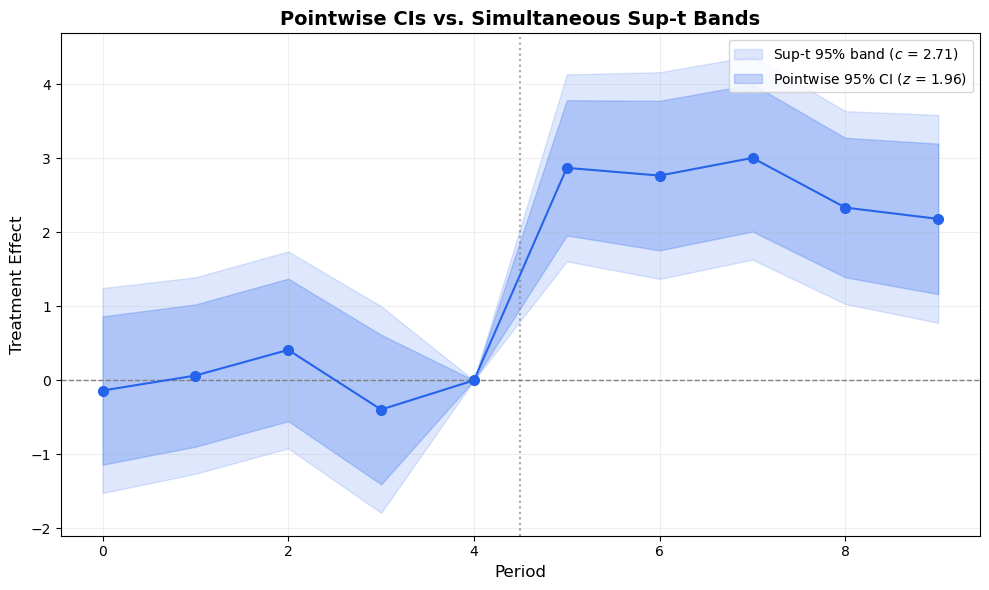

In [6]:
#| label: fig-supt
#| fig-cap: "Pointwise CIs (dark blue) vs. simultaneous sup-t bands (light blue). The sup-t bands maintain 95% joint coverage across all periods — the honest standard for testing parallel trends."
#| code-fold: true

# SE for non-reference periods (reference has se=0)
se_nz = np.array([results.period_effects[p].se for p in periods_all])
est_nz = np.array([results.period_effects[p].effect for p in periods_all])
periods_nz = np.array(periods_all)

fig, ax = plt.subplots(figsize=(10, 6))

# Sup-t bands (outer, lighter)
supt_lo = np.zeros(len(periods_plot))
supt_hi = np.zeros(len(periods_plot))
pw_lo = np.zeros(len(periods_plot))
pw_hi = np.zeros(len(periods_plot))

j = 0
for i, p in enumerate(periods_plot):
    if p == ref_period:
        supt_lo[i] = 0.0
        supt_hi[i] = 0.0
        pw_lo[i] = 0.0
        pw_hi[i] = 0.0
    else:
        supt_lo[i] = est_nz[j] - c_supt * se_nz[j]
        supt_hi[i] = est_nz[j] + c_supt * se_nz[j]
        pw_lo[i] = est_nz[j] - c_pointwise * se_nz[j]
        pw_hi[i] = est_nz[j] + c_pointwise * se_nz[j]
        j += 1

ax.fill_between(periods_plot, supt_lo, supt_hi,
                alpha=0.15, color='#2563eb', label=f'Sup-t 95% band ($c$ = {c_supt:.2f})')
ax.fill_between(periods_plot, pw_lo, pw_hi,
                alpha=0.25, color='#2563eb', label=f'Pointwise 95% CI ($z$ = {c_pointwise:.2f})')
ax.plot(periods_plot, est_plot, 'o-', color='#2563eb', markersize=7, linewidth=1.5, zorder=3)

ax.axhline(0, color='gray', linestyle='--', linewidth=1)
ax.axvline(ref_period + 0.5, color='gray', linestyle=':', linewidth=1.5, alpha=0.7)
ax.set_xlabel('Period', fontsize=12)
ax.set_ylabel('Treatment Effect', fontsize=12)
ax.set_title('Pointwise CIs vs. Simultaneous Sup-t Bands', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

The sup-t bands are wider — that's the price of joint coverage. Use them when making joint statements like:

- "All pre-treatment coefficients are jointly insignificant" (parallel trends)
- "The treatment effect is significant at *every* post-treatment period"

Pointwise CIs remain useful for period-specific inference ("what is the effect at $t=7$?").

# Parenthetical Outcome Labels

Event study coefficients show *changes* relative to a reference period. But a coefficient of $\hat{\beta}_7 = 3.2$ is hard to interpret without knowing the **baseline level** of the outcome.

Is 3.2 economically large or small? If the average outcome at the reference period is 40, then $3.2 / 40 \approx 8\%$ — a meaningful effect. If it's 400, then $3.2 / 400 \approx 0.8\%$ — perhaps negligible.

Freyaldenhoven et al. (2021) recommend adding a **parenthetical label** on the y-axis showing the baseline outcome level, like:

> **0 (41.94)**

This tells the reader: "the normalized zero on this axis corresponds to an outcome level of 41.94." Readers can then immediately compute percentage effects in their heads.

In [7]:
# Compute the baseline outcome: average of treated group at reference period
baseline_outcome = data[
    (data['treated'] == 1) & (data['period'] == ref_period)
]['outcome'].mean()

print(f'Average outcome for treated group at reference period {ref_period}: {baseline_outcome:.2f}')

Average outcome for treated group at reference period 4: 11.91


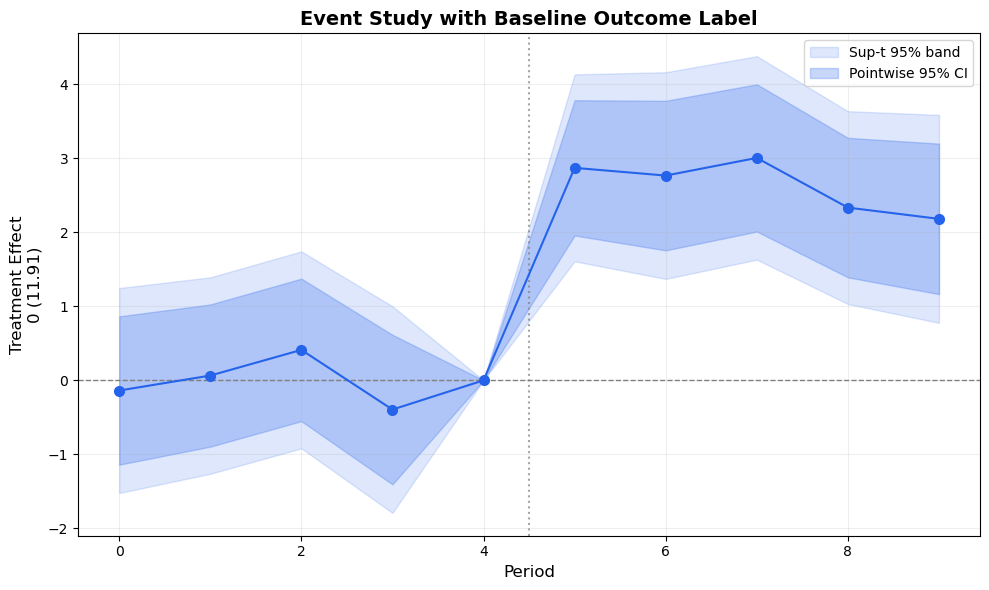

In [8]:
#| label: fig-outcome-label
#| fig-cap: "The parenthetical label '0 (XX.XX)' on the y-axis tells the reader the baseline outcome level, enabling immediate computation of percentage effects."
#| code-fold: true

fig, ax = plt.subplots(figsize=(10, 6))

ax.fill_between(periods_plot, supt_lo, supt_hi,
                alpha=0.15, color='#2563eb', label='Sup-t 95% band')
ax.fill_between(periods_plot, pw_lo, pw_hi,
                alpha=0.25, color='#2563eb', label='Pointwise 95% CI')
ax.plot(periods_plot, est_plot, 'o-', color='#2563eb', markersize=7, linewidth=1.5, zorder=3)

ax.axhline(0, color='gray', linestyle='--', linewidth=1)
ax.axvline(ref_period + 0.5, color='gray', linestyle=':', linewidth=1.5, alpha=0.7)

# Parenthetical outcome label on y-axis
ax.set_ylabel(f'Treatment Effect\n0 ({baseline_outcome:.2f})', fontsize=12)

ax.set_xlabel('Period', fontsize=12)
ax.set_title('Event Study with Baseline Outcome Label', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

# Joint Pre-Trend Wald Test

Eyeballing whether pre-treatment coefficients "look close to zero" is subjective and has low statistical power. A formal **joint Wald test** provides a proper statistical answer.

Under the null hypothesis of parallel trends, all pre-treatment coefficients are jointly zero:

$$H_0: \beta_{-K} = \beta_{-K+1} = \cdots = \beta_{-2} = 0$$

The Wald statistic is:

$$W = \hat{\boldsymbol{\beta}}_{\text{pre}}^\prime \, \hat{V}_{\text{pre}}^{-1} \, \hat{\boldsymbol{\beta}}_{\text{pre}} \sim \chi^2(K-1)$$

where $\hat{\boldsymbol{\beta}}_{\text{pre}}$ is the vector of pre-treatment coefficients and $\hat{V}_{\text{pre}}$ is their variance-covariance sub-matrix.

::: {.callout-note}
## Already in diff-diff for Imputation DiD
The `ImputationDiD` estimator has a built-in `pretrend_test()` method (Borusyak et al. 2024, Equation 9). The implementation below is a **generalized version** that works with any estimator that provides a VCV matrix, including `MultiPeriodDiD`.
:::

In [9]:
def pretrend_wald_test(estimates, vcov, pre_indices):
    """
    Joint Wald test for pre-treatment coefficients = 0.
    
    Parameters
    ----------
    estimates : array-like
        All event study coefficient estimates (excluding reference).
    vcov : array-like
        VCV matrix for these estimates.
    pre_indices : list of int
        Indices into estimates/vcov for pre-treatment coefficients.
    
    Returns
    -------
    dict with 'f_stat', 'p_value', 'df'
    """
    beta_pre = np.array([estimates[i] for i in pre_indices])
    V_pre = vcov[np.ix_(pre_indices, pre_indices)]
    
    k = len(beta_pre)
    W = beta_pre @ np.linalg.solve(V_pre, beta_pre)
    p_value = 1 - scipy_stats.chi2.cdf(W, df=k)
    
    return {'f_stat': W, 'p_value': p_value, 'df': k}

In [10]:
# Identify pre-treatment indices (all periods < reference)
pre_periods = [p for p in periods_all if p < ref_period]
pre_indices = [periods_all.index(p) for p in pre_periods]

pt_test = pretrend_wald_test(estimates, vcov_es, pre_indices)

print(f'Joint Pre-Trend Wald Test')
print(f'  H0: beta_pre = 0 (parallel trends)')
print(f'  Chi2({pt_test["df"]}) = {pt_test["f_stat"]:.3f}')
print(f'  p-value = {pt_test["p_value"]:.4f}')
if pt_test['p_value'] > 0.05:
    print(f'  -> Fail to reject parallel trends at 5% level')
else:
    print(f'  -> Reject parallel trends at 5% level')

Joint Pre-Trend Wald Test
  H0: beta_pre = 0 (parallel trends)
  Chi2(4) = 2.315
  p-value = 0.6781
  -> Fail to reject parallel trends at 5% level


# Leveling-Off Test

Once we've established a treatment effect exists, a natural follow-up question is: **are the post-treatment effects constant over time, or do they grow/decay?**

If effects are approximately constant, we can summarize them with a single average ATT — a much simpler message. The **leveling-off test** formalizes this:

$$H_0: \beta_0 = \beta_1 = \cdots = \beta_K$$

We test this using a contrast matrix $R$ that takes successive differences of the post-treatment coefficients:

$$R = \begin{pmatrix} -1 & 1 & 0 & \cdots \\ 0 & -1 & 1 & \cdots \\ \vdots & & \ddots & \end{pmatrix}$$

The Wald statistic is:

$$W = (R\hat{\boldsymbol{\beta}}_{\text{post}})^\prime (R\hat{V}_{\text{post}}R^\prime)^{-1} (R\hat{\boldsymbol{\beta}}_{\text{post}}) \sim \chi^2(K)$$

If we fail to reject, it's reasonable to summarize the post-treatment effects with a **constant effects step function**: a flat line at the average post-treatment coefficient.

In [11]:
def leveling_off_test(estimates, vcov, post_indices):
    """
    Test H0: all post-treatment coefficients are equal.
    
    Parameters
    ----------
    estimates : array-like
        All event study coefficient estimates (excluding reference).
    vcov : array-like
        VCV matrix for these estimates.
    post_indices : list of int
        Indices into estimates/vcov for post-treatment coefficients.
    
    Returns
    -------
    dict with 'f_stat', 'p_value', 'df', 'avg_effect'
    """
    beta_post = np.array([estimates[i] for i in post_indices])
    V_post = vcov[np.ix_(post_indices, post_indices)]
    
    k = len(beta_post)
    
    # Contrast matrix: successive differences
    R = np.zeros((k - 1, k))
    for i in range(k - 1):
        R[i, i] = -1
        R[i, i + 1] = 1
    
    Rb = R @ beta_post
    RVR = R @ V_post @ R.T
    
    W = Rb @ np.linalg.solve(RVR, Rb)
    p_value = 1 - scipy_stats.chi2.cdf(W, df=k - 1)
    
    # Average effect (for step function overlay)
    avg_effect = np.mean(beta_post)
    
    return {'f_stat': W, 'p_value': p_value, 'df': k - 1, 'avg_effect': avg_effect}

In [12]:
# Identify post-treatment indices
post_periods = [p for p in periods_all if p > ref_period]
post_indices = [periods_all.index(p) for p in post_periods]

lo_test = leveling_off_test(estimates, vcov_es, post_indices)

print(f'Leveling-Off Test')
print(f'  H0: beta_post are all equal (constant effects)')
print(f'  Chi2({lo_test["df"]}) = {lo_test["f_stat"]:.3f}')
print(f'  p-value = {lo_test["p_value"]:.4f}')
print(f'  Average post-treatment effect: {lo_test["avg_effect"]:.3f}')
if lo_test['p_value'] > 0.05:
    print(f'  -> Fail to reject constant effects')
    print(f'  -> Can summarize with average ATT = {lo_test["avg_effect"]:.3f}')
else:
    print(f'  -> Reject constant effects (effects vary over time)')

Leveling-Off Test
  H0: beta_post are all equal (constant effects)
  Chi2(4) = 3.398
  p-value = 0.4936
  Average post-treatment effect: 2.633
  -> Fail to reject constant effects
  -> Can summarize with average ATT = 2.633


# Putting It All Together

Now let's combine all five enhancements into a single publication-ready event study plot:

1. **Sup-t bands** (outer, light) alongside pointwise CIs (inner, dark)
2. **Parenthetical outcome label** on the y-axis
3. **Pre-trend Wald test** p-value shown below the plot
4. **Leveling-off test** p-value shown below the plot
5. **Constant effects step function** overlaid when leveling-off is not rejected

In [13]:
def plot_event_study_enhanced(
    results,
    data,
    *,
    outcome_col='outcome',
    treatment_col='treated',
    time_col='period',
    alpha=0.05,
    n_sim=50000,
    show_supt=True,
    show_baseline_outcome=True,
    show_pretrend_pval=True,
    show_leveloff_pval=True,
    show_constant_fit=True,
    color='#2563eb',
    figsize=(11, 7),
    title='Event Study',
):
    """
    Enhanced event study plot with Freyaldenhoven et al. (2021) best practices.
    """
    ref_period = results.reference_period
    all_periods = sorted(results.period_effects.keys())
    
    # Extract estimates and SEs
    est = np.array([results.period_effects[p].effect for p in all_periods])
    se = np.array([results.period_effects[p].se for p in all_periods])
    
    # Full period array including reference
    p_plot = sorted(all_periods + [ref_period])
    e_plot = np.array([0.0 if p == ref_period else results.period_effects[p].effect for p in p_plot])
    s_plot = np.array([0.0 if p == ref_period else results.period_effects[p].se for p in p_plot])
    p_plot = np.array(p_plot)
    
    # VCV sub-matrix
    idx_map = results.interaction_indices
    idx_list = [idx_map[p] for p in all_periods]
    vcov = results.vcov[np.ix_(idx_list, idx_list)]
    
    # Critical values
    z = scipy_stats.norm.ppf(1 - alpha / 2)
    c_sup = compute_supt_critical_value(vcov, alpha=alpha, n_sim=n_sim) if show_supt else z
    
    # Pre/post indices
    pre_idx = [all_periods.index(p) for p in all_periods if p < ref_period]
    post_idx = [all_periods.index(p) for p in all_periods if p > ref_period]
    
    # Tests
    pt = pretrend_wald_test(est, vcov, pre_idx) if show_pretrend_pval else None
    lo = leveling_off_test(est, vcov, post_idx) if show_leveloff_pval else None
    
    # Baseline outcome
    baseline = None
    if show_baseline_outcome:
        baseline = data[
            (data[treatment_col] == 1) & (data[time_col] == ref_period)
        ][outcome_col].mean()
    
    # --- Plot ---
    fig, ax = plt.subplots(figsize=figsize)
    
    # Bands
    if show_supt:
        ax.fill_between(p_plot, e_plot - c_sup * s_plot, e_plot + c_sup * s_plot,
                        alpha=0.12, color=color, label=f'Sup-t {int((1-alpha)*100)}% band')
    ax.fill_between(p_plot, e_plot - z * s_plot, e_plot + z * s_plot,
                    alpha=0.25, color=color, label=f'Pointwise {int((1-alpha)*100)}% CI')
    ax.plot(p_plot, e_plot, 'o-', color=color, markersize=7, linewidth=1.5, zorder=3)
    
    # Constant effects step function
    if show_constant_fit and lo is not None and lo['p_value'] > alpha:
        post_periods_arr = np.array([p for p in p_plot if p > ref_period])
        ax.hlines(lo['avg_effect'],
                  xmin=post_periods_arr[0] - 0.3, xmax=post_periods_arr[-1] + 0.3,
                  color='#dc2626', linewidth=2.5, linestyle='-', alpha=0.8,
                  label=f'Constant fit ({lo["avg_effect"]:.2f})', zorder=2)
    
    # Reference lines
    ax.axhline(0, color='gray', linestyle='--', linewidth=1)
    ax.axvline(ref_period + 0.5, color='gray', linestyle=':', linewidth=1.5, alpha=0.7)
    
    # Labels
    ax.set_xlabel('Period', fontsize=12)
    if baseline is not None:
        ax.set_ylabel(f'Treatment Effect\n0 ({baseline:.2f})', fontsize=12)
    else:
        ax.set_ylabel('Treatment Effect', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.legend(fontsize=9, loc='upper left')
    ax.grid(True, alpha=0.2)
    
    # Test annotations below the plot
    footnotes = []
    if pt is not None:
        footnotes.append(
            f'Pre-trend Wald test: $\\chi^2$({pt["df"]}) = {pt["f_stat"]:.2f}, '
            f'p = {pt["p_value"]:.3f}'
        )
    if lo is not None:
        footnotes.append(
            f'Leveling-off test: $\\chi^2$({lo["df"]}) = {lo["f_stat"]:.2f}, '
            f'p = {lo["p_value"]:.3f}'
        )
    if footnotes:
        footnote_text = '    |    '.join(footnotes)
        ax.text(0.5, -0.12, footnote_text,
                transform=ax.transAxes, fontsize=9.5, ha='center',
                color='#444444', style='italic')
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)
    plt.show()
    
    return {'pretrend_test': pt, 'leveloff_test': lo, 'baseline_outcome': baseline,
            'c_supt': c_sup if show_supt else None}

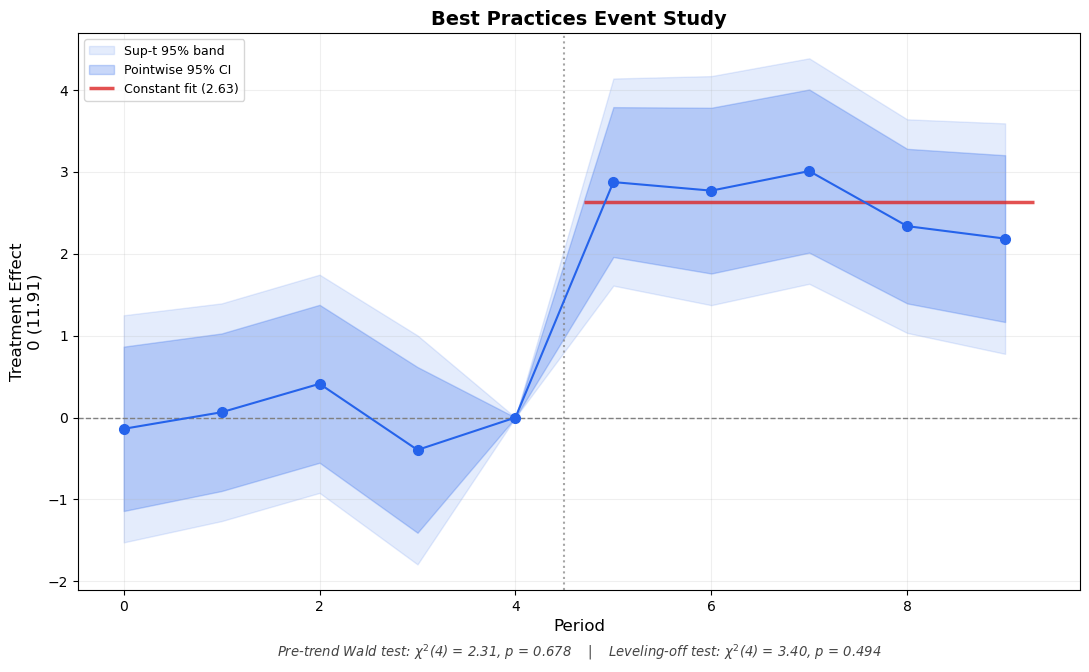

In [14]:
#| label: fig-combined
#| fig-cap: "The complete best-practices event study: simultaneous bands, baseline outcome label, formal test p-values, and constant effects fit. Compare with @fig-baseline."
#| code-fold: true

info = plot_event_study_enhanced(
    results, data,
    title='Best Practices Event Study',
)

Compare @fig-combined with @fig-baseline. The enhanced version communicates much more:

- The **outer band** shows that pre-treatment coefficients are jointly consistent with zero (sup-t band covers zero for all pre-periods)
- The **parenthetical label** lets readers immediately gauge economic magnitude
- The **p-values** provide formal statistical answers instead of visual guessing
- The **constant fit line** (shown when the leveling-off test does not reject) gives a clean summary of the post-treatment effect

All of this can be produced with a single function call.

# Before and After

To drive the point home, here is a side-by-side comparison:

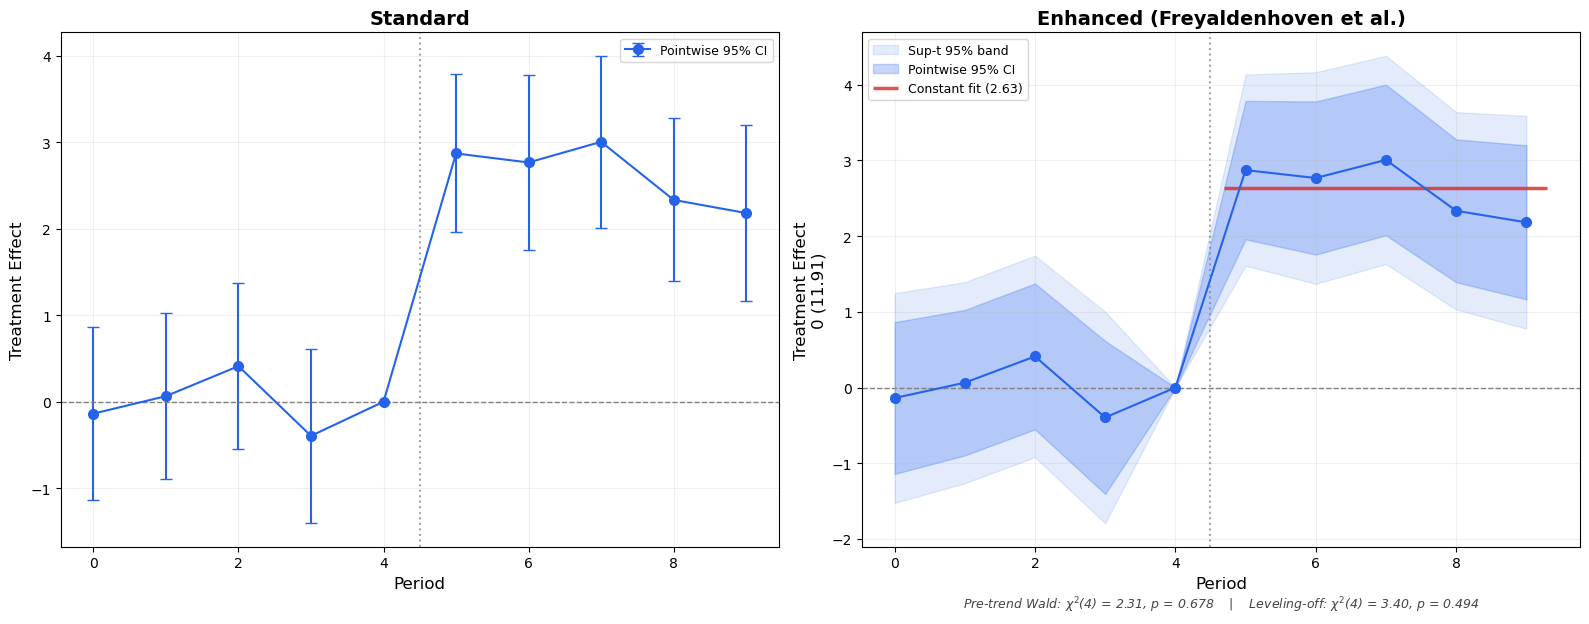

In [15]:
#| label: fig-before-after
#| fig-cap: "Before (standard) vs. After (enhanced). The same data, the same estimates — but the enhanced version communicates far more to the reader."
#| code-fold: true

fig, axes = plt.subplots(1, 2, figsize=(16, 6.5))

# --- Left: Standard ---
ax = axes[0]
ax.errorbar(periods_plot, est_plot, yerr=z * se_plot,
            fmt='o-', color='#2563eb', capsize=4, markersize=7,
            linewidth=1.5, label='Pointwise 95% CI')
ax.axhline(0, color='gray', linestyle='--', linewidth=1)
ax.axvline(ref_period + 0.5, color='gray', linestyle=':', linewidth=1.5, alpha=0.7)
ax.set_xlabel('Period', fontsize=12)
ax.set_ylabel('Treatment Effect', fontsize=12)
ax.set_title('Standard', fontsize=14, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.2)

# --- Right: Enhanced ---
ax = axes[1]

# Sup-t band
ax.fill_between(periods_plot, est_plot - c_supt * se_plot, est_plot + c_supt * se_plot,
                alpha=0.12, color='#2563eb', label='Sup-t 95% band')
# Pointwise
ax.fill_between(periods_plot, est_plot - z * se_plot, est_plot + z * se_plot,
                alpha=0.25, color='#2563eb', label='Pointwise 95% CI')
ax.plot(periods_plot, est_plot, 'o-', color='#2563eb', markersize=7, linewidth=1.5, zorder=3)

# Constant fit
if lo_test['p_value'] > 0.05:
    post_p = periods_plot[periods_plot > ref_period]
    ax.hlines(lo_test['avg_effect'],
              xmin=post_p[0] - 0.3, xmax=post_p[-1] + 0.3,
              color='#dc2626', linewidth=2.5, linestyle='-', alpha=0.8,
              label=f'Constant fit ({lo_test["avg_effect"]:.2f})', zorder=2)

ax.axhline(0, color='gray', linestyle='--', linewidth=1)
ax.axvline(ref_period + 0.5, color='gray', linestyle=':', linewidth=1.5, alpha=0.7)
ax.set_xlabel('Period', fontsize=12)
ax.set_ylabel(f'Treatment Effect\n0 ({baseline_outcome:.2f})', fontsize=12)
ax.set_title('Enhanced (Freyaldenhoven et al.)', fontsize=14, fontweight='bold')
ax.legend(fontsize=9, loc='upper left')
ax.grid(True, alpha=0.2)

# Footnotes
footnote = (
    f'Pre-trend Wald: $\chi^2$({pt_test["df"]}) = {pt_test["f_stat"]:.2f}, '
    f'p = {pt_test["p_value"]:.3f}    |    '
    f'Leveling-off: $\chi^2$({lo_test["df"]}) = {lo_test["f_stat"]:.2f}, '
    f'p = {lo_test["p_value"]:.3f}'
)
ax.text(0.5, -0.12, footnote, transform=ax.transAxes, fontsize=9, ha='center',
        color='#444444', style='italic')

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
plt.show()

# Conclusions

Standard event study plots are a good starting point, but they can — and should — communicate more. The five enhancements from [Freyaldenhoven et al. (2021)](https://doi.org/10.3386/w29170) are all straightforward to implement and add substantial value:

| Enhancement | What It Adds | When to Use |
|-------------|-------------|-------------|
| **Sup-t bands** | Joint coverage across all periods | Always (especially for pre-trend assessment) |
| **Outcome label** | Economic magnitude interpretation | Always |
| **Pre-trend Wald test** | Formal parallel trends test | Always |
| **Leveling-off test** | Constant vs. dynamic effects | When summarizing post-treatment effects |
| **Constant fit line** | Visual summary of average ATT | When leveling-off is not rejected |

The `plot_event_study_enhanced()` function wraps all of these into a single call. It works with any `MultiPeriodDiD` result that provides a variance-covariance matrix.

These are **presentation** improvements — they make existing results clearer. For **robustness** improvements (what to do when parallel trends might not hold), see our companion post on sensitivity analysis with HonestDiD, smoothest confounding paths, and functional SCBs.

# References

- Freyaldenhoven, S., Hansen, C., Pérez, J. P., & Shapiro, J. M. (2021). Visualization, Identification, and Estimation in the Linear Panel Event-Study Design. *NBER Working Paper No. 29170*.
- Montiel Olea, J. L., & Plagborg-Møller, M. (2019). Simultaneous Confidence Bands: Theory, Implementation, and an Application to SVARs. *Journal of Applied Econometrics*, 34(1), 1-17.
- Borusyak, K., Jaravel, X., & Spiess, J. (2024). Revisiting Event Study Designs: Robust and Efficient Estimation. *Review of Economic Studies*, 91(6), 3253-3285.
- Roth, J. (2022). Pretest with Caution: Event-Study Estimates after Testing for Parallel Trends. *American Economic Review: Insights*, 4(3), 305-322.
- Gerber, I. (2025). diff-diff: A comprehensive Python package for Difference-in-Differences. [GitHub](https://github.com/igerber/diff-diff).